<h1>An introduction to how to deal with data as a function of time with Python</h1>

<h3>Before we learn how to download data from an SQL database, we start with basic functionality of input/output (IO) and plotting.<br>
For this, I prepared a few files that we will use. They are also found in the ConditionMonitoring directory. We will need some Python packages to begin with, i.e. numpy (handling arrays), pandas (handling data tables), matplotlib (handling plots), scipy (for some built-in statistical methods), and astropy (for units and conversions).</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from astropy.coordinates import SkyCoord
from astropy.time import Time

In [2]:
# this is my personal style file, comment out when you try to run the code, or create your own
plt.style.use('thomas')

<h3>Database files typically come as CSV files or ascii tables or excel tables or ...; Pandas can handle all of those by creating a "data frame" to store the file content:</h3>

In [3]:
df1 = pd.read_csv('COSI_aspect_DSO.csv')

In [4]:
df1

,unixtime_full,heading,pitch,roll,latitude,longitude,altitude
0,2016-06-11 09:43:51,140.49,-0.40,-0.63,-17.27,-97.88,32676.21
1,2016-06-11 09:43:52,140.39,-0.49,-0.58,-17.27,-97.88,32676.54
2,2016-06-11 09:43:53,140.27,-0.51,-0.53,-17.27,-97.88,32676.87
3,2016-06-11 09:43:54,140.17,-0.49,-0.57,-17.27,-97.88,32677.20
4,2016-06-11 09:43:55,140.03,-0.48,-0.56,-17.27,-97.88,32677.55
...,...,...,...,...,...,...,...
172773,2016-06-13 09:43:48,0.00,0.00,0.00,0.00,0.00,0.00
172774,2016-06-13 09:43:49,0.00,0.00,0.00,0.00,0.00,0.00
172775,2016-06-13 09:43:50,0.00,0.00,0.00,0.00,0.00,0.00
172776,2016-06-13 09:43:51,0.00,0.00,0.00,0.00,0.00,0.00


<h3>Here you see 8 columns, the first of which is just the index, then the time, heading, pitch, roll, latitude, longitude and altitude. There are no units attached to the values, and no explanation for the moment. So we need to look up what they mean. In the email I sent you, there is the users guide with information about all entries in each of the files. I selected only a few to start with, and only a selected time span.</h3>

<h3>Yaw, pitch and roll are standard aviation definitions, i.e. standard rotation angles along defined air- or spacecraft axes. Heading is the compass coordinate where the balloon is ... headed. They are given in degrees. The longitutude and latitude are the coordinates of the balloon on Earth in degrees, and the altitude is the altitude above NN.</h3>

<h3>To access the columns, we use the dataframe like a Pythoon dictionary:</h3>

In [5]:
df1['heading']

0         140.49
1         140.39
2         140.27
3         140.17
4         140.03
           ...  
172773      0.00
172774      0.00
172775      0.00
172776      0.00
172777      0.00
Name: heading, Length: 172778, dtype: float64

<h3>To get the values (instead of the column object with index, etc.), we add the attribute .values:</h3>

In [6]:
df1['heading'].values

array([140.49, 140.39, 140.27, ...,   0.  ,   0.  ,   0.  ])

<h3>This returns an array with 172778 entries. We save that as new array so that we can play around with the array. We do the same for the other arrays (NB: this is not necessary, but helps when coding larger things):</h3> 

In [7]:
unix_time = df1['unixtime_full'].values
heading = df1['heading'].values
pitch = df1['pitch'].values
roll = df1['roll'].values
latitude = df1['latitude'].values
longitude = df1['longitude'].values
altitude = df1['altitude'].values

<h3>Let's plot longitude vs latitude as an example:</h3>

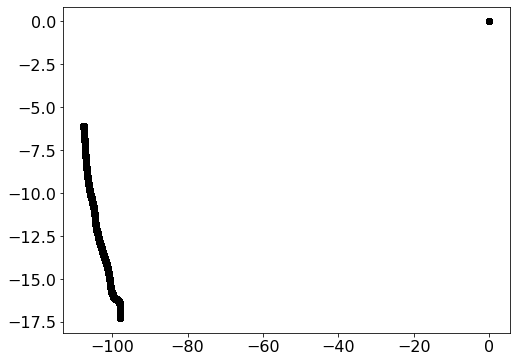

In [8]:
plt.plot(longitude,latitude,'o')

<h3>It appears that the balloon was moving from (lon,lat) = (-110,-6) to (-17,-95) (by eye), and then teleported to (0,0). Of course, such datasets always contain outliers and false measurements. Here, the balloon was certainly not at (0,0) suddenly, but those values actually indicate non-measurements. There are several different ways to get rid of those things. I prefer to work with index arrays, i.e. I search where the lon and lat values are 0 and 0 (both at the same time), and select only the other indices to plot and work with. That means I create a "mask" that I iteratively update when I find more outliers from other parameters:</h3>

In [9]:
mask = np.where((longitude != 0) & (latitude != 0))

In [10]:
mask

(array([     0,      1,      2, ..., 168141, 168142, 168143]),)

<h3>Such a mask can be multiple arrays when we have multiple dimensions. Here is is one-dimensional, so we can pick the 0th dimension as index array for useful data points:</h3>

In [11]:
mask = mask[0]

<h3>Now we can plot the masked arrays:</h3>

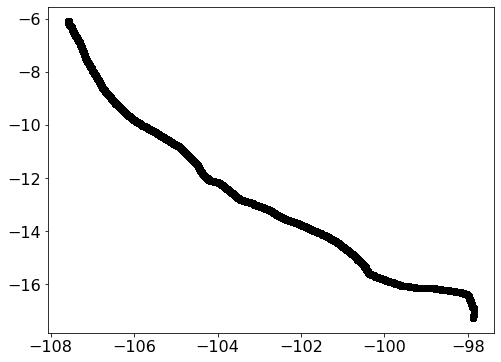

In [12]:
plt.plot(longitude[mask],latitude[mask],'o')

<h3>The non-measurements are gone and we see the flight path more clearly.</h3>

<h3>We actually do not know the flight path: Here we don't know the starting point and end point, and how long the balloon was at a certain position. First we mark the first an last entry by a coloured symbol, then we have a closer look at the times:</h3>

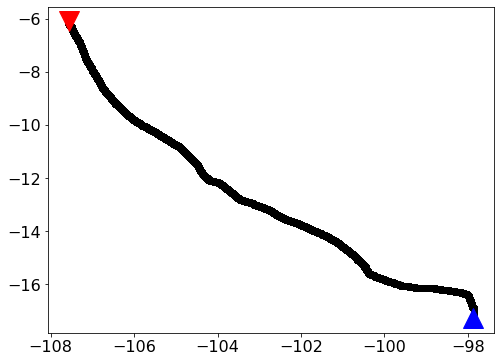

In [13]:
# as before
plt.plot(longitude[mask],latitude[mask],'o')
# zeroth entry is the first one, b^ means a blue triangle as plotting symbol
plt.plot(longitude[mask][0],latitude[mask][0],'b^',markersize=20)
# -1st entry is the last one, rv means a red triangle (upside down) as plotting symbol
plt.plot(longitude[mask][-1],latitude[mask][-1],'rv',markersize=20)

<h3>We see that the path is actually reversed to the statement from above.</h3>

<h3>The array unix_time contains strings, i.e. text instead of numbers, indicated by the 'text'. Plotting dates is a delicate task because we would want a running number instead of plotting each date separately. For this, we convert the string arrays from unix_time into a running number, for example into Julian Days (JD) or Modified Julian Days (MJD):</h3>

In [14]:
unix_time

array(['2016-06-11 09:43:51', '2016-06-11 09:43:52',
       '2016-06-11 09:43:53', ..., '2016-06-13 09:43:50',
       '2016-06-13 09:43:51', '2016-06-13 09:43:51'], dtype=object)

<h3>The astropy Time() class can handle such (properly formatted) strings, and easly convert them into other time formats:</h3>

In [15]:
t0 = Time(unix_time[0])
t0

<Time object: scale='utc' format='iso' value=2016-06-11 09:43:51.000>

<h3>t0 is now an object that has the scale 'utc', format 'iso', and the value attached to it as given by the zeroth entry of the unix_time array. If we convert this to JD, for example, we see the following:</h3>

In [16]:
t0.jd

2457550.905451389

<h3>This is the value that we are interested in. A running number that we can properly compare to other values.<br>To get a new time array that includes the JD and MJD values, we first have to create a properly formatted time array. The format "iso" can be ambiguous, which is why typically a "T" is placed between the date and the time, which is equal to the format "isot":</h3>

In [17]:
unix_time_isot = np.array([val.replace(' ','T') for val in unix_time])

In [18]:
unix_time_isot

array(['2016-06-11T09:43:51', '2016-06-11T09:43:52',
       '2016-06-11T09:43:53', ..., '2016-06-13T09:43:50',
       '2016-06-13T09:43:51', '2016-06-13T09:43:51'], dtype='<U19')

<h3>Now we create a Time() object with all times from the new time array included, and convert them to JD and MJD, respectively, to save them as new arrays:</h3?

In [19]:
unix_Time = Time(unix_time_isot,scale='utc',format='isot')

In [20]:
unix_Time

<Time object: scale='utc' format='isot' value=['2016-06-11T09:43:51.000' '2016-06-11T09:43:52.000'
 '2016-06-11T09:43:53.000' ... '2016-06-13T09:43:50.000'
 '2016-06-13T09:43:51.000' '2016-06-13T09:43:51.000']>

In [21]:
jd_time = unix_Time.jd
mjd_time = unix_Time.mjd

In [22]:
jd_time

array([2457550.90545139, 2457550.90546296, 2457550.90547454, ...,
       2457552.90543982, 2457552.90545139, 2457552.90545139])

In [23]:
mjd_time

array([57550.40545139, 57550.40546296, 57550.40547454, ...,
       57552.40543981, 57552.40545139, 57552.40545139])

<h3>How we can plot the longitude and latitude, for example, as a function of time:</h3>

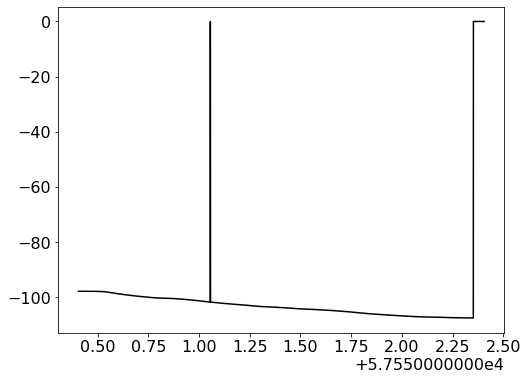

In [24]:
plt.plot(mjd_time,longitude)

<h3>Again, we see that some values are just not taken, and we use the mask in addition:</h3>

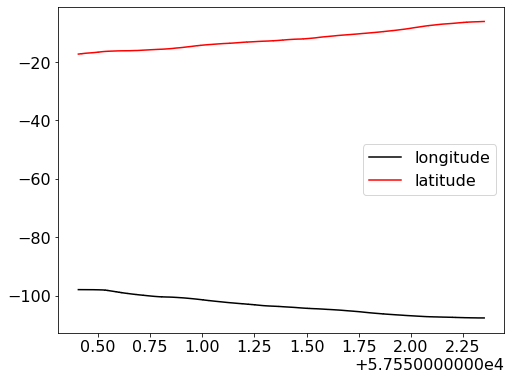

In [25]:
plt.plot(mjd_time[mask],longitude[mask],label='longitude')
plt.plot(mjd_time[mask],latitude[mask],label='latitude')
plt.legend()

<h3>I added a legend to the plot by given the plot commands labels, and then calling the legend() function.<br>We see that the axis labels are missing, and might also consider that the +5.75500000e4 is not a nice style (can be hard to read). We therefore again define a new time array with minutes since MJD 57550:</h3>

In [26]:
mjd_time_min = (mjd_time - 57550)*24*60

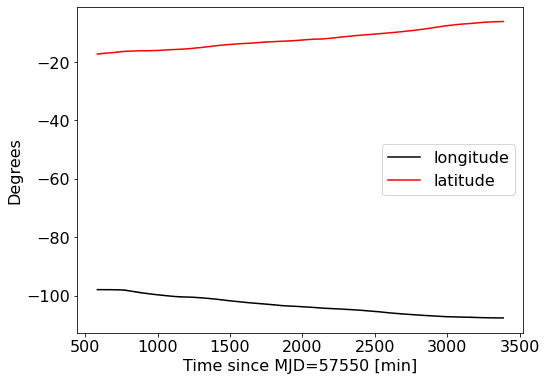

In [27]:
plt.plot(mjd_time_min[mask],longitude[mask],label='longitude')
plt.plot(mjd_time_min[mask],latitude[mask],label='latitude')
plt.xlabel('Time since MJD=57550 [min]')
plt.ylabel('Degrees')
plt.legend()

<h3>Now we can also look at the heading, pitch and roll:</h3>

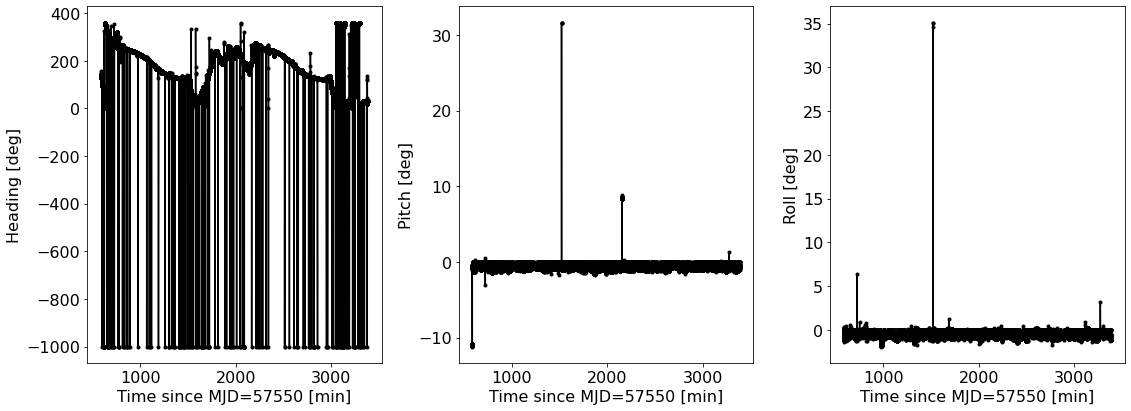

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.plot(mjd_time_min[mask],heading[mask],'.-')
plt.xlabel('Time since MJD=57550 [min]')
plt.ylabel('Heading [deg]')

plt.subplot(132)
plt.plot(mjd_time_min[mask],pitch[mask],'.-')
plt.xlabel('Time since MJD=57550 [min]')
plt.ylabel('Pitch [deg]')

plt.subplot(133)
plt.plot(mjd_time_min[mask],roll[mask],'.-')
plt.xlabel('Time since MJD=57550 [min]')
plt.ylabel('Roll [deg]')

plt.tight_layout()

<h3>Now we see many more outliers: in the Heading plot, a lot of values as negative and at the same negative value. That's an indication that something went wrong there. In the Pitch and Roll plots, it also seems like there are many outliers. We will check this step by step:</h3>

Text(0, 0.5, 'Heading [deg]')

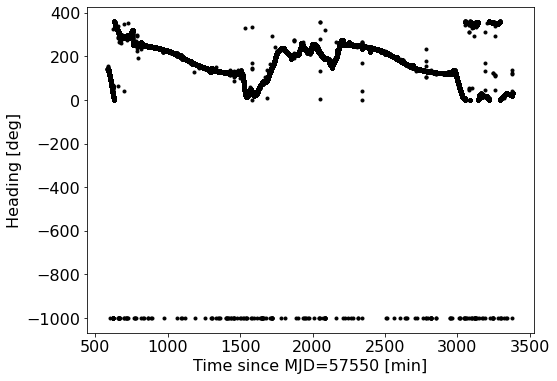

In [29]:
plt.plot(mjd_time_min[mask],heading[mask],'.')
plt.xlabel('Time since MJD=57550 [min]')
plt.ylabel('Heading [deg]')

<h3>Heading should be defined between 0 and 360 degrees (like on a compass), so that we can deselect any negative value here. I define a new mask here so that it becomes clear later what we selected and deselected:</h3>

In [30]:
mask2 = np.where(heading >= 0)[0]

<h3>We can treat index arrays as mathematical sets, so that we can build the intersection to select a combined mask:</h3>

In [31]:
mask_tot = np.intersect1d(mask,mask2)

In [32]:
len(mask),len(mask2),len(mask_tot)

(168143, 172583, 167948)

<h3>We see that the total mask contains fewer elements than either mask or mask2.</h3>

Text(0, 0.5, 'Heading [deg]')

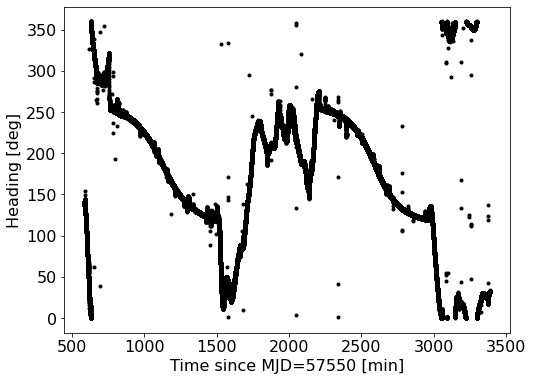

In [33]:
plt.plot(mjd_time_min[mask_tot],heading[mask_tot],'.')
plt.xlabel('Time since MJD=57550 [min]')
plt.ylabel('Heading [deg]')

<h3>This makes more sense: the balloon is heading toward a direction and direction changes are rather smoothly. Note that 0 deg and 360 deg are the same. Heading is a difficult to understand quantity if not properly visualised: From a pole, everything would be heading south, but where the aircraft ends up is not just define by heading.<br>However, what we also see aree points that don't align with the other points: These could be true outliers, which we want to filter now. There are many (many!) possibilities to do that. The easiest one (for indivdual outliers) is the median filter.</h3>

In [34]:
from scipy.ndimage import median_filter, uniform_filter1d, gaussian_filter1d

<h3>The median filter orders values in a window of size N, say [1,5,2,6,3,140,2,1,5,4] (with N=10, and with 140 being the outlier) to [1,1,2,2,3,4,5,5,6,140] and returns the central point, or if there are two central points, thee mean of the two, so here it would be (3+4)/2 = 3.5. Then it moves one entry further, say [5,2,6,3,140,2,1,5,4,7] and does the same, returning (4+5)/2 = 4.5, and so on. This means, the 140 will be replaced by values closer to the other neighouring values -- it is therefore filtered. Suppose we want to look at the median filter on a time scale of 3, 20, and 180 seconds, we do:</h3>

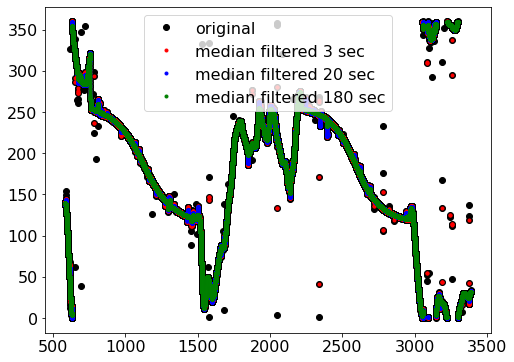

In [35]:
plt.plot(mjd_time_min[mask_tot],median_filter(heading[mask_tot],1),'ko',label='original')
plt.plot(mjd_time_min[mask_tot],median_filter(heading[mask_tot],3),'r.',label='median filtered 3 sec')
plt.plot(mjd_time_min[mask_tot],median_filter(heading[mask_tot],20),'b.',label='median filtered 20 sec')
plt.plot(mjd_time_min[mask_tot],median_filter(heading[mask_tot],180),'g.',label='median filtered 180 sec')
plt.legend()

<h3>We see that in the case of 3 seconds, only individual outliers are removed (because the window is only 3 entries); for 20 seconds, most points appear only on the global trend, and for 180 seconds, there is even some smoothing included, which might not be appropriate to do in certain cases.</h3>

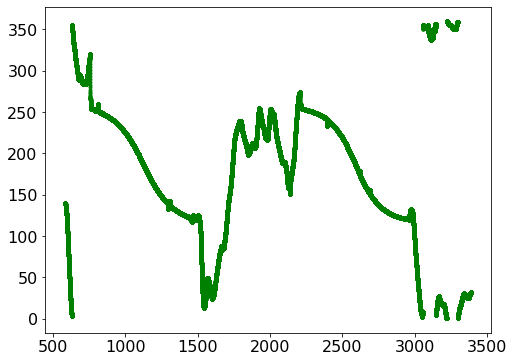

In [36]:
plt.plot(mjd_time_min[mask_tot],median_filter(heading[mask_tot],180),'g.',label='median filtered 180 sec')

<h3>The median filter (also the mean filter, etc.) returns a calculated value for the specific entry that is filtered. As a first order approximation, this might be useful, however could lead to a false impression that everything is OK when instead things are running out of order. Suppose the outliers are real (and not just bad measurements, for example), and we want to mark those. How do we know when to raise an alert? The most simple answer is a threshold detection algorithm: We calculate the running median or mean, and check with the running standard deviation, if new values are above (or below) a certain threshold, say "$3\sigma$", i.e. three standard deviations.<br>For this purpose, we select a sub-array between 1000 and 1400 minutes:</h3>

In [37]:
tdx = np.where((mjd_time_min[mask_tot] >= 1000) & (mjd_time_min[mask_tot] <= 1400))[0]

In [38]:
mjd_time2 = mjd_time_min[mask_tot][tdx]
heading2 = heading[mask_tot][tdx]
pitch2 = pitch[mask_tot][tdx]
roll2 = roll[mask_tot][tdx]

<h3>NB: this is always the same command, one should build a function or class to do this.</h3>

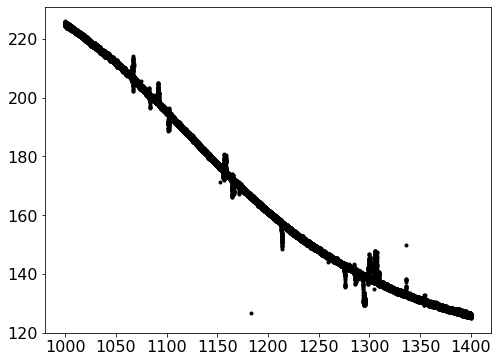

In [39]:
plt.plot(mjd_time2,heading2,'k.')

<h3>The question is now: are all of these things outliers or are they compatible with the standard deviation from the measurements? We define a running standard deviation with the help of pandas:</h3>

In [40]:
head_std003 = pd.Series(heading[mask_tot][tdx]).rolling(3).std().values
head_std020 = pd.Series(heading[mask_tot][tdx]).rolling(20).std().values
head_std180 = pd.Series(heading[mask_tot][tdx]).rolling(180).std().values

<h3>The mathematical expression we want to test is:<br>
    if $|x-\hat{x}| \leq N\sigma$ then accept value, and<br>
    if $|x-\hat{x}| > N\sigma$ then reject the value (being an outlier)<br>
    with $N$ being a threshold that is calibrated from the measurements themselves, empirically, and $\hat{x}$ is the median- or mean-filtered data.</h3>

In [41]:
N = 3
good_points003 = np.where(np.abs(heading2 - median_filter(heading2,3)) <= N*head_std003)[0]
good_points020 = np.where(np.abs(heading2 - median_filter(heading2,20)) <= N*head_std020)[0]
good_points180 = np.where(np.abs(heading2 - median_filter(heading2,180)) <= N*head_std180)[0]

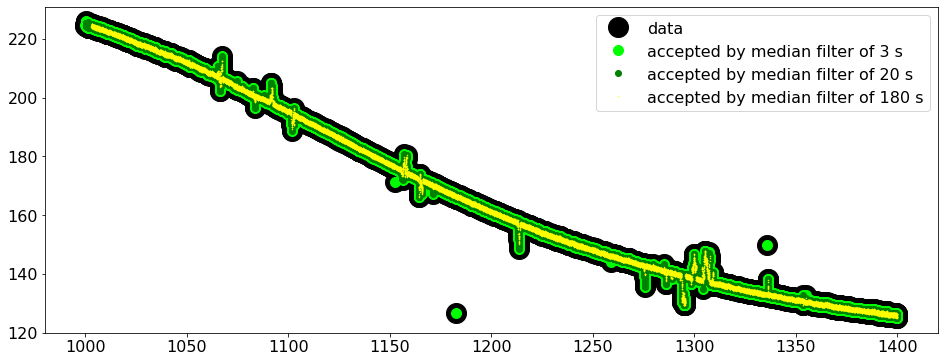

In [42]:
plt.figure(figsize=(16,6))
plt.plot(mjd_time2,heading2,'ko',label='data',markersize=20)
plt.plot(mjd_time2[good_points003],heading2[good_points003],'o',color='lime',label='accepted by median filter of 3 s',markersize=10)
plt.plot(mjd_time2[good_points020],heading2[good_points020],'o',color='green',label='accepted by median filter of 20 s')
plt.plot(mjd_time2[good_points180],heading2[good_points180],'.',color='yellow',label='accepted by median filter of 180 s',markersize=1)
plt.legend()

<h3>The first thing we notice is that the individual low and high points around 1180 and 1330 min are accepted by a median filter of 3 seconds, but not of a 20 or 180 second filter.

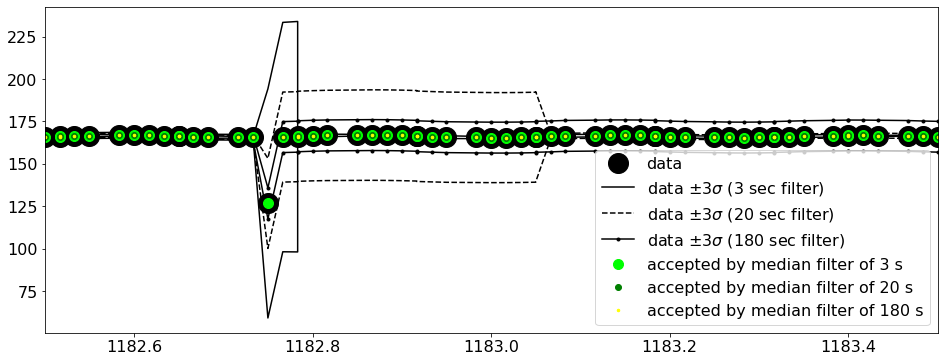

In [43]:
plt.figure(figsize=(16,6))
plt.plot(mjd_time2,heading2,'ko',label='data',markersize=20)
plt.plot(mjd_time2,heading2+N*head_std003,'k-',label=r'data $\pm 3\sigma$ (3 sec filter)')
plt.plot(mjd_time2,heading2-N*head_std003,'k-')
plt.plot(mjd_time2,heading2+N*head_std020,'k--',label=r'data $\pm 3\sigma$ (20 sec filter)')
plt.plot(mjd_time2,heading2-N*head_std020,'k--')
plt.plot(mjd_time2,heading2+N*head_std180,'k.-',label=r'data $\pm 3\sigma$ (180 sec filter)')
plt.plot(mjd_time2,heading2-N*head_std180,'k.-')
plt.plot(mjd_time2[good_points003],heading2[good_points003],'o',color='lime',label='accepted by median filter of 3 s',markersize=10)
plt.plot(mjd_time2[good_points020],heading2[good_points020],'o',color='green',label='accepted by median filter of 20 s')
plt.plot(mjd_time2[good_points180],heading2[good_points180],'.',color='yellow',label='accepted by median filter of 180 s',markersize=5)
plt.xlim(1182.5,1183.5)
plt.legend()

<h3>The black curves now define the regions that should be included or exluded. For single points, even the standard deviation of a window of only 3 points would accept that outlier. The two larget windows (20 and 180 sec) reject that point.</h3>

<h3>For the apparent wiggles, for example at between 1200 and 1250 min, we also check what is going on in more detail:</h3>

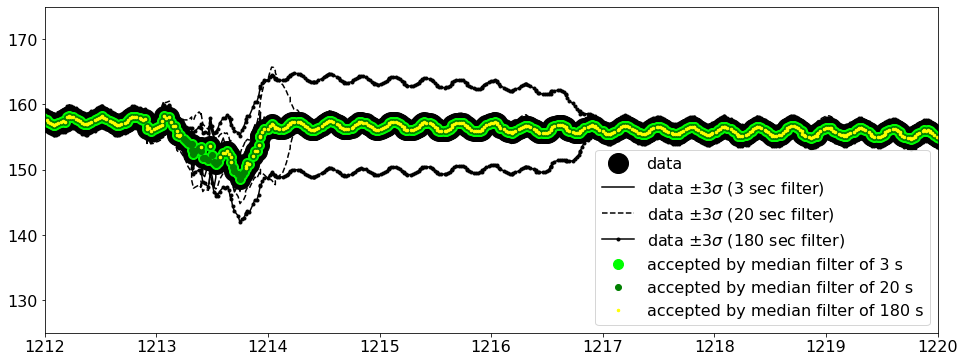

In [44]:
plt.figure(figsize=(16,6))
plt.plot(mjd_time2,heading2,'ko',label='data',markersize=20)
plt.plot(mjd_time2,heading2+N*head_std003,'k-',label=r'data $\pm 3\sigma$ (3 sec filter)')
plt.plot(mjd_time2,heading2-N*head_std003,'k-')
plt.plot(mjd_time2,heading2+N*head_std020,'k--',label=r'data $\pm 3\sigma$ (20 sec filter)')
plt.plot(mjd_time2,heading2-N*head_std020,'k--')
plt.plot(mjd_time2,heading2+N*head_std180,'k.-',label=r'data $\pm 3\sigma$ (180 sec filter)')
plt.plot(mjd_time2,heading2-N*head_std180,'k.-')
plt.plot(mjd_time2[good_points003],heading2[good_points003],'o',color='lime',label='accepted by median filter of 3 s',markersize=10)
plt.plot(mjd_time2[good_points020],heading2[good_points020],'o',color='green',label='accepted by median filter of 20 s')
plt.plot(mjd_time2[good_points180],heading2[good_points180],'.',color='yellow',label='accepted by median filter of 180 s',markersize=5)
plt.xlim(1212,1220)
plt.ylim(125,175)
plt.legend()

<h3>We see that this wiggle might actually be a true measurement (no erratic behaviour). With a filter of 20 seconds, the data points would all be accepted. For a filter of 180 seconds, several points would be rejected. This could be an indication of a true anomaly and one could send an alert.</h3>

<h3>Summarising the running mean and standard deviation method (also called $\sigma$-clipping), we have to distinguish between filtering unreliable measurements, and possibly triggering an alert. This has to be judged empirically, from the dataset itself, from models, experience, and calibrating the method.</h3>

<h2>Next steps:<br>
    Look at the other files I uploaded, and try to figure out what is seen. Plot the results, filter unreliable measurements, and mark anomalies.<br>
    Try out different filters, plot different data in different visualisations. Plot rates against rates and fnid correlations, and calculate those correlations.</h2>